<a href="https://colab.research.google.com/github/alixmacdonald10/TRACKER/blob/main/TRACKER_PreProcessing_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREREQUISITS

##Mount drive


In [ ]:
from google.colab import drive
 
# mount drive to access files
 
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Install requirements

In [ ]:
# install weights and bias for logging
!pip install wandb -qqq
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# NN imports
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorboard

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████                        | 209.8 MB 1.4 MB/s eta 0:07:14ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.7/http/client.py", line 465, in read
    n = self.readinto(b)
  File "/usr/lib/python3.7/http/client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.7/ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3

In [ ]:
# database specific imports
!pip3 install h5py

##Imports

In [ ]:
%load_ext tensorboard
import torch
from torch.utils import data
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler

import h5py
import numpy as np
from pathlib import Path
import random
import time
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

##Check Cuda

In [ ]:
# Check devices
num_devices = torch.cuda.device_count()
print(f'Number of cuda devices: {num_devices}')
for device in range(0, num_devices):
  device_name = torch.cuda.get_device_name(device)
  print(f'Cuda device name: {device_name}')

Number of cuda devices: 1
Cuda device name: Tesla P100-PCIE-16GB


#MODEL INFORMATION

##Set hyper parameters

In [ ]:
# define hyper parameters
project_name = 'Tracker-PreProcessing-Denoising'
verbose = 1  # print out helpers
transformed_when = 'after patches'
transform1 = 'hflip'
transform2 = 'rotate'
patch_size = 256
patch_stride = (12 * patch_size)
plot_itterations = 1
num_epoch = 2
max_itterations = 4e5
initial_learning_rate = 2e-4
min_learning_rate = 1e-7
loss_type = "PSNR"
scheduler_type = "cosine_annealing"
optimizer_type = "Adam"
if optimizer_type == "SGD":
  batch = 1
else:
  batch = 2
mini_batch_size = 4
fpath = '/content/gdrive/MyDrive/Programming/datasets/noisyDataset.hdf5'

In [ ]:
# Track hyperparameters and run metadata
hyperparameters = {
  "device_name": device_name,
  "transformed_when": transformed_when,
  "transform1": transform1,
  "transform2": transform2,
  "verbose": verbose,
  "patch_size": patch_size,
  "patch_stride": patch_stride,
  "plot_itterations": plot_itterations,
  "batch": batch,
  "mini_batch_size": mini_batch_size,
  "num_epoch": num_epoch,
  "max_itterations": max_itterations,
  "initial_learning_rate": initial_learning_rate,
  "min_learning_rate": min_learning_rate,
  "scheduler_type": scheduler_type,
  "loss_type": "PSNR",
  "optimizer_type": optimizer_type,
  "architecture": "HINet",
  "dataset": "Smartphone Image Denoising Dataset (SIDD)",
  "project_name": project_name
}

##Define model

###Note for transfer learning and importing pre-trained models

In [ ]:
''' 
Models can be imported from saved files and transfer learned by:
 
'''
#from torchvision import models
 
#model = models.resnet101(pretrained=True)
 
# TO ONLY TRAIN THE LAST LAYER (TRANSFER LEARNING) DO THE FOLLOWING
#for param in model.parameters():
#   param.requires_grad = False  # freezes all layers in beginning
 
# return number of features in output (to transfer learn)
#num_ftrs = model.fc.in_features
 
# set output fully connected using
#model.fc = nn.Linear(num_ftrs, 2)   # (input layers, output layers)
#model.to(device)

' \nModels can be imported from saved files and transfer learned by:\n \n'

###Model Architecture

In [ ]:
'''
HINet: Half Instance Normalization Network for Image Restoration
@inproceedings{chen2021hinet,
  title={HINet: Half Instance Normalization Network for Image Restoration},
  author={Liangyu Chen and Xin Lu and Jie Zhang and Xiaojie Chu and Chengpeng Chen},
  booktitle={IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops},
  year={2021}
}
'''


def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer

def conv_down(in_chn, out_chn, bias=False):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=4, stride=2, padding=1, bias=bias)
    return layer

def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)

## Supervised Attention Module
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size=3, bias=True):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

class HINet(nn.Module):

    def __init__(self, in_chn=3, wf=64, depth=5, relu_slope=0.2, hin_position_left=0, hin_position_right=4):
        super(HINet, self).__init__()
        self.depth = depth
        self.down_path_1 = nn.ModuleList()
        self.down_path_2 = nn.ModuleList()
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)
        self.conv_02 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        prev_channels = self.get_input_chn(wf)
        for i in range(depth): #0,1,2,3,4
            use_HIN = True if hin_position_left <= i and i <= hin_position_right else False
            downsample = True if (i+1) < depth else False
            self.down_path_1.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, use_HIN=use_HIN))
            self.down_path_2.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, use_csff=downsample, use_HIN=use_HIN))
            prev_channels = (2**i) * wf

        self.up_path_1 = nn.ModuleList()
        self.up_path_2 = nn.ModuleList()
        self.skip_conv_1 = nn.ModuleList()
        self.skip_conv_2 = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path_1.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.up_path_2.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.skip_conv_1.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            self.skip_conv_2.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            prev_channels = (2**i)*wf
        self.sam12 = SAM(prev_channels)
        self.cat12 = nn.Conv2d(prev_channels*2, prev_channels, 1, 1, 0)

        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        image = x
        #stage 1
        x1 = self.conv_01(image)
        encs = []
        decs = []
        for i, down in enumerate(self.down_path_1):
            if (i+1) < self.depth:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                x1 = down(x1)

        for i, up in enumerate(self.up_path_1):
            x1 = up(x1, self.skip_conv_1[i](encs[-i-1]))
            decs.append(x1)

        sam_feature, out_1 = self.sam12(x1, image)
        #stage 2
        x2 = self.conv_02(image)
        x2 = self.cat12(torch.cat([x2, sam_feature], dim=1))
        blocks = []
        for i, down in enumerate(self.down_path_2):
            if (i+1) < self.depth:
                x2, x2_up = down(x2, encs[i], decs[-i-1])
                blocks.append(x2_up)
            else:
                x2 = down(x2)

        for i, up in enumerate(self.up_path_2):
            x2 = up(x2, self.skip_conv_2[i](blocks[-i-1]))

        out_2 = self.last(x2)
        out_2 = out_2 + image
        return [out_1, out_2]

    def get_input_chn(self, in_chn):
        return in_chn

    def _initialize(self):
        gain = nn.init.calculate_gain('leaky_relu', 0.20)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=gain)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample, relu_slope, use_csff=False, use_HIN=False):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.identity = nn.Conv2d(in_size, out_size, 1, 1, 0)
        self.use_csff = use_csff

        self.conv_1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_1 = nn.LeakyReLU(relu_slope, inplace=False)
        self.conv_2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_2 = nn.LeakyReLU(relu_slope, inplace=False)

        if downsample and use_csff:
            self.csff_enc = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.csff_dec = nn.Conv2d(out_size, out_size, 3, 1, 1)

        if use_HIN:
            self.norm = nn.InstanceNorm2d(out_size//2, affine=True)
        self.use_HIN = use_HIN

        if downsample:
            self.downsample = conv_down(out_size, out_size, bias=False)

    def forward(self, x, enc=None, dec=None):
        out = self.conv_1(x)

        if self.use_HIN:
            out_1, out_2 = torch.chunk(out, 2, dim=1)
            out = torch.cat([self.norm(out_1), out_2], dim=1)
        out = self.relu_1(out)
        out = self.relu_2(self.conv_2(out))

        out += self.identity(x)
        if enc is not None and dec is not None:
            assert self.use_csff
            out = out + self.csff_enc(enc) + self.csff_dec(dec)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, relu_slope):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.conv_block = UNetConvBlock(in_size, out_size, False, relu_slope)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], 1)
        out = self.conv_block(out)
        return out

class Subspace(nn.Module):

    def __init__(self, in_size, out_size):
        super(Subspace, self).__init__()
        self.blocks = nn.ModuleList()
        self.blocks.append(UNetConvBlock(in_size, out_size, False, 0.2))
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, bias=True)

    def forward(self, x):
        sc = self.shortcut(x)
        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        return x + sc


class skip_blocks(nn.Module):

    def __init__(self, in_size, out_size, repeat_num=1):
        super(skip_blocks, self).__init__()
        self.blocks = nn.ModuleList()
        self.re_num = repeat_num
        mid_c = 128
        self.blocks.append(UNetConvBlock(in_size, mid_c, False, 0.2))
        for i in range(self.re_num - 2):
            self.blocks.append(UNetConvBlock(mid_c, mid_c, False, 0.2))
        self.blocks.append(UNetConvBlock(mid_c, out_size, False, 0.2))
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, bias=True)

    def forward(self, x):
        sc = self.shortcut(x)
        for m in self.blocks:
            x = m(x)
        return x + sc

###Dataset

**NOTE:** The dataset section can vary between analysis!

####Dataset class and transforms

In [ ]:
# define dataset class

class HDF5Dataset(data.Dataset):
  """Represents a HDF5 dataset. with X = 'data' and y = 'labels'
  
  Input params:
      file_path: Path to the HDF5 file
      transform: PyTorch transform to apply to every data instance (default=None).
  """
  def __init__(self, config, file_loc=None, transform=True):
    super().__init__()
    self.transform = transform
    self.config = config

    P = Path(file_loc)
    # Search for all h5 files in path
    self.file = h5py.File(P, 'r')
    # return number of samples
    self.n_samples = len(self.file.get('data'))
    
    # create patches of patch_size
    self.patch_size = config.patch_size
    self.stride = config.patch_stride  # for even patches
       

  def __getitem__(self, index):
    '''
    returns items X and y. If config
    '''
    X, y = self.load_file(index)  # -> [w, h, c]

    if self.config.transformed_when == 'before':
      if self.transform:
        X, y = transform_func(X, y, self.config)
    else:    
      X = torch.from_numpy(np.float32(X)).permute(2, 0, 1)  # -> [c, w, h]
      if self.config.patch_size > 0:
        X = X.unfold(1, self.patch_size, self.stride).unfold(2, self.patch_size, self.stride).unfold(3, self.patch_size, self.stride) # -> [c, vert_patches, horiz_patches, img, height, width]
        X = torch.flatten(X, start_dim=1, end_dim=3).permute(1, 0, 2, 3) / 255 # -> [patches, c, height, width]  0 to 1 

      y = torch.from_numpy(np.float32(y)).permute(2, 0, 1)  # -> [c, w, h]
      if self.config.patch_size > 0:
        y = y.unfold(1, self.patch_size, self.stride).unfold(2, self.patch_size, self.stride).unfold(3, self.patch_size, self.stride) # -> [c, vert_patches, horiz_patches, img, height, width]
        y = torch.flatten(y, start_dim=1, end_dim=3).permute(1, 0, 2, 3) / 255 # -> [patches, c, height, width]  0 to 1

      num_patches = int(X.shape[0])

      if self.transform:
        for img in range(0, num_patches):
          X_temp, y_temp = transform_func(X[img], y[img], self.config)
          X_temp = X_temp[None, :, :]
          y_temp = y_temp[None, :, :]
          torch.cat((X, X_temp), 0)
          torch.cat((y, y_temp), 0)
    return (X, y)


  def __len__(self):
    # allows length of dataset to be returned
    return self.n_samples


  def load_file(self, index):
    ''' load index of database '''
    X = self.file.get('data')[index]
    y = self.file.get('labels')[index]

    return (X, y)

In [ ]:
class MiniBatchDataset(HDF5Dataset):
  """Represents a HDF5 dataset. with X = 'data' and y = 'labels'
  
  Input params:
      file_path: Path to the HDF5 file
      transform: PyTorch transform to apply to every data instance (default=None).
  """
  def __init__(self, X, y, config):
    super().__init__(config, fpath)
    assert X.shape[0] == y.shape[0] # assuming shape[0] = dataset size
    self.X = X
    self.y = y

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]


In [ ]:
  #transform functions
  
  def transform_func(image, label, config):

      '''
      Apply transforms to image and label
      '''
      
      # convert to PIL image
      image = transforms.functional.to_pil_image(image)
      label = transforms.functional.to_pil_image(label)

      if config.transform1 == "hflip":
        # Random horizontal flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            label = transforms.functional.hflip(label)

      if config.transform1 == "hflip":
        # Random 90 deg rotation
        if random.random() > 0.5:
            image = transforms.functional.rotate(image, 90)
            label = transforms.functional.rotate(label, 90)

      # Transform to tensor
      image = transforms.functional.to_tensor(image)
      label = transforms.functional.to_tensor(label)

      return image, label

####Split dataset into train, val, test split

In [ ]:
def train_val_test_split(dataset):

  # perform random splits on dataset to return train, val, test sets (manual seed fixes output for repeatable results , remove device = cuda for non. GPU )
  dataset_length = len(dataset)

  # set sizes
  train_set_size = 0.8
  val_set_size = 0.1
  test_set_size = 0.1

  # return lengths
  train_set_length = round(train_set_size * dataset_length, 0)
  val_set_length = round(val_set_size * dataset_length, 0)
  test_set_length = dataset_length - train_set_length - val_set_length

  # check
  total = train_set_length + val_set_length + test_set_length
  print(f'total length: {total} / train set length: {train_set_length} / validation set length: {val_set_length} / test set length: {test_set_length}')
  assert total == dataset_length

  # create datasets
  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
      dataset,
      [int(train_set_length), int(val_set_length), int(test_set_length)],
      generator=torch.Generator().manual_seed(42)
  )

  return train_dataset, val_dataset, test_dataset


####Test plot functions

In [ ]:
def test_plot_Xy_batch(dataset):
 
  # plot images
  num_cols = 4
  num_patches = int(num_cols / 2)
  num_rows = 2
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 16), sharey=True)
  fig.suptitle("Train sample example images")

  row = 0
  for image in range(0, num_rows):  # plot two images in batch
    X, y = dataset.__getitem__(image)
    col = 0
    for patch in range(0, num_patches):  #plot patches
      X_img_patches = X.permute(0, 2, 3, 1)
      X_img = X_img_patches[patch]

      y_img_patches = y.permute(0, 2, 3, 1)
      y_img = y_img_patches[patch]

      axs[row, col].imshow(X_img)
      axs[row, col].title.set_text(f'Batch {image} X train example patch {patch}')
      col += 1
      axs[row, col].imshow(y_img)
      axs[row, col].title.set_text(f'Batch {image} y train example patch {patch}')
      col += 1
    row += 1

In [ ]:
def test_plot_Xy_train_val_test_dataset(train_dataset, val_dataset, test_dataset):
  # Get dataset items
  test_index = 1
  X_train, y_train = train_dataset.__getitem__(test_index)
  X_val, y_val = val_dataset.__getitem__(test_index)
  X_test, y_test = test_dataset.__getitem__(test_index)

  patch = 0
  
  # plot images
  fig, axs = plt.subplots(3, 2, figsize=(16, 16), sharey=True)
  fig.suptitle("Train, validation, test dataset sample example images")
  axs[0, 0].imshow(X_train.permute(0, 2, 3, 1)[patch])
  axs[0, 0].title.set_text('X train example image')
  axs[0, 1].imshow(y_train.permute(0, 2, 3, 1)[patch])
  axs[0, 1].title.set_text('y train example image')
  axs[1, 0].imshow(X_val.permute(0, 2, 3, 1)[patch])
  axs[1, 0].title.set_text('X validation example image')
  axs[1, 1].imshow(y_val.permute(0, 2, 3, 1)[patch])
  axs[1, 1].title.set_text('y validation example image')
  axs[2, 0].imshow(X_test.permute(0, 2, 3, 1)[patch])
  axs[2, 0].title.set_text('X test example image')
  axs[2, 1].imshow(y_test.permute(0, 2, 3, 1)[patch])
  axs[2, 1].title.set_text('y test example image')

###Custom Loss Function 

In [ ]:
# create custom PSNRLoss class

class PSNRLoss(nn.Module):

  def __init__(self):
    super(PSNRLoss, self).__init__()

  def forward(self, R, X, y, data_range=1.0, reduction='mean', convert_to_greyscale=False):
      r"""Compute Peak Signal-to-Noise Ratio for a batch of images.
      Supports both greyscale and color images with RGB channel order.
      Args:
          R: An input tensor. Shape :math:`(2, N, C, H, W)`.  where position 0 is [stage1 output, stage 2 output] -> outputs from model
          x: An input tensor. Shape :math:`(N, C, H, W)`.
          y: A target tensor. Shape :math:`(N, C, H, W)`.
          data_range: Maximum value range of images (usually 1.0 or 255).
          reduction: Specifies the reduction type:
              ``'none'`` | ``'mean'`` | ``'sum'``. Default: ``'mean'``
          convert_to_greyscale: Convert RGB image to YCbCr format and computes PSNR
              only on luminance channel if `True`. Compute on all 3 channels otherwise.
      Returns:
          PSNR Index of similarity betwen two images.
      References:
          https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
      """
      # Constant for numerical stability
      EPS = 1e-8

      X = X / float(data_range)
      y = y / float(data_range)
      R[0] = (R[0] / float(data_range)).to(device)
      R[1] = (R[1] / float(data_range)).to(device)
      

      if (X.size(1) == 3) and convert_to_greyscale:
          # Convert RGB image to YCbCr and take luminance: Y = 0.299 R + 0.587 G + 0.114 B
          rgb_to_grey = torch.tensor([0.299, 0.587, 0.114]).view(1, -1, 1, 1).to(X)
          R[0] = torch.sum(R[0] * rgb_to_grey, dim=1, keepdim=True)
          R[1] = torch.sum(R[1] * rgb_to_grey, dim=1, keepdim=True)
          X = torch.sum(X * rgb_to_grey, dim=1, keepdim=True)
          y = torch.sum(y * rgb_to_grey, dim=1, keepdim=True)

      score = []
      for i in range(0, len(R)):
        mse = torch.mean(((R[i].add(X)) - y) ** 2, dim=[1, 2, 3])
        max_value = 1. if X[0].max() <= 1 else 255. # max pixel value
        score.append(20. * torch.log10(max_value / torch.sqrt(mse)))

      summed_loss = score[0].add(score[1])
      summed_loss = -1. * summed_loss

      return _reduced(summed_loss, reduction) # reduced to single value

    
def _reduced(loss, reduction_type):
  r"""Reduce input in batch dimension if needed.
  Args:
      x: Tensor with shape (N, *).
      reduction: Specifies the reduction type:
          ``'none'`` | ``'mean'`` | ``'sum'``. Default: ``'mean'``
  """
  if reduction_type == 'none':
      return loss
  elif reduction_type == 'mean':
      return loss.mean(dim=0)
  elif reduction_type == 'sum':
      return loss.sum(dim=0)
  else:
      raise ValueError("Uknown reduction. Expected one of {'none', 'mean', 'sum'}")



###Make model

In [ ]:
def make(config, device):
    
    verbose = config.verbose

    # create dataset
    file_loc = fpath
    dataset = HDF5Dataset(config, file_loc=fpath, transform=True)
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
    
    if verbose==1:
      # plot dataset info
      test_plot_Xy_batch(train_dataset)
      test_plot_Xy_train_val_test_dataset(train_dataset, val_dataset, test_dataset)

    # create dataloader
    train_dataloader = make_loader(config, train_dataset)
    val_dataloader = make_loader(config, val_dataset)
    test_dataloader = make_loader(config, test_dataset)
    # set up a dictionary of dataloaders for train and val
    dataloader = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}
    dataset_sizes = {'train': len(train_dataloader), 'val': len(val_dataloader), 'test': len(test_dataloader)} 
    if verbose==1:
      print(f'Dataset sizes: {dataset_sizes}')

    # Make the model
    model = HINet().to(device)

    # set loss type
    if config.loss_type == "PSNR":
      criterion = PSNRLoss().to(device)  # custom loss
    elif config.loss_type == "MSE":
      criterion = MSELoss().to(device)

    # set optimizer type
    if config.optimizer_type == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr=config.initial_learning_rate)
    elif config.optimizer_type == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr=config.initial_learning_rate)

    # set learning rate scheduler 
    if config.scheduler_type == "cosine_annealing":
      model_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.max_itterations, eta_min=config.min_learning_rate, last_epoch=-1, verbose=False)


    return model, dataloader, dataset_sizes, criterion, optimizer, model_lr_scheduler

####Dataloader

In [ ]:
def make_loader(config, dataset):
    loader = data.DataLoader(
        dataset=dataset,
        batch_size=config.batch, 
        shuffle=False,
        pin_memory=False, 
        num_workers=1
    )
    return loader

###Training Loop

In [ ]:
# training loop
def train_model(model, config, device, dataloader, dataset_sizes, criterion, optimizer, scheduler):
  verbose = config.verbose
  plot_itter = config.plot_itterations
  num_epochs = config.num_epoch
  mini_batch_size = config.mini_batch_size
  # tell wandb to watch
  wandb.watch(model, criterion, log="all", log_freq=plot_itter)
  # start timer
  since = time.time()
  if verbose == 1:
    print('Total progress...')
  #initialise variables
  output_dict = {
      'epoch': [],
      'images': [],
      'labels': [],
      'outputs': [],
      'loss': [],
      'learning rate': [initial_learning_rate],
      'num_training_examples': 0
  }
  num_itters = 0
  num_training_examples = 0
  num_validation_examples = 0
  # load existing best weights and reset accuracy
  best_model_wts = copy.deepcopy(model.state_dict())

  # begin analysis
  for epoch in tqdm(range(num_epochs)):
    if num_itters > max_itterations:
      break
    else:
      print(f'\nEpoch {epoch + 1} / {num_epochs}')
      print('-' * 10)

      for phase in ['train', 'val']:
        since_phase = time.time()
        if verbose == 1:
          print(f'Phase -> {phase}')
          print(f'Batches...')
          print('-' * 10)
        # loop train and val phase for each dataset
        best_loss = 1e5  # large so always saves best loss
        epoch_running_loss = 0
        epoch_loss = 0
        total_imgs_in_batches = 0
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader[phase])):
          # get images and labels
          images_batch = torch.flatten(images, start_dim=0, end_dim=1)  # -> [imgs (batch*patches), channels, height, width]
          plt.imshow(images_batch[0].permute(1, 2, 0).to('cpu'))
          labels_batch = torch.flatten(labels, start_dim=0, end_dim=1)       
          imgs_in_batch = images_batch.shape[0]
          total_imgs_in_batches += imgs_in_batch

          # create dataset for mini-batches
          mini_batch_data = MiniBatchDataset(images_batch, labels_batch, config) 
          mini_batch_dataloader = make_loader(config, mini_batch_data) 
          print(f'Mini-batches -> Total training examples = {num_training_examples}')
          print('-' * 10)
          for mini_batch_idx, (mini_batch_images, mini_batch_labels) in enumerate(mini_batch_dataloader):
            # get images labels and indices
            mini_batch_images = mini_batch_images.to(device)  # -> [mb, c, h, w]
            mini_batch_labels = mini_batch_labels.to(device)
            imgs_in_mini_batch = mini_batch_images.shape[0]
            if phase == 'train':  # TRAINING
              model.train().to(device)  # set to training mode
              # FORWARD PASS
              with torch.set_grad_enabled(True):
                outputs = model(mini_batch_images) # -> [mini_batch, channels, height, width] -> outputs is [out_1 (STAGE 1 output image), out_2 (STAGE 2 output image)]
                loss = criterion(outputs, mini_batch_images, mini_batch_labels, data_range=1.0, reduction='mean').to(device)
                num_training_examples += mini_batch_images.shape[0]
                epoch_running_loss += (loss.item() * imgs_in_mini_batch)  # mult by batch to allow avg (epoch loss) to be calcd.
                
                # BACKWARD PASS
                optimizer.zero_grad()  # emptys cache
                loss.backward()
                optimizer.step()
                scheduler.step()
                num_itters += 1


            else:  # VALIDATION
              model.eval()  # set to training mode
              # FORWARD PASS
              with torch.set_grad_enabled(False):
                outputs = model(mini_batch_images) # -> [mini_batch, channels, height, width] -> outputs is [out_1 (STAGE 1 output image), out_2 (STAGE 2 output image)]
                loss = criterion(outputs, mini_batch_images, mini_batch_labels, data_range=1.0, reduction='mean').to(device)
                num_validation_examples += mini_batch_images.shape[0]
                epoch_running_loss += (loss.item() * imgs_in_mini_batch)
                num_itters += 1
          
          if epoch+1 % plot_itter == 0 and batch_idx == 0 and phase == 'val':  # every Xth val epoch save data for plotting
            output_dict['epoch'].append(epoch)
            output_dict['images'].append(mini_batch_images.to('cpu'))
            output_dict['labels'].append(mini_batch_labels.to('cpu'))
            output_dict['outputs'].append([outputs[0].to('cpu'), outputs[1].to('cpu')])
        
        phase_time = time.time() - since_phase 
        print(f'Epoch {epoch+1} {phase} time: {phase_time // 60:.0f}m {phase_time % 60:.0f}s')
        # log epoch loss
        epoch_loss = epoch_running_loss / total_imgs_in_batches # average of epoch losses
        epoch_phase_log(epoch_loss, num_training_examples, epoch, phase)
        if epoch % plot_itter == 0 and batch_idx == 0 and phase == 'val':  # every Xth val epoch save data for plotting
            output_dict['loss'].append(epoch_loss)

        # deep copy the model
        # print(type(phase))
        # print(type(epoch_loss))
        # print(type(best_loss))
        if phase == 'val' and epoch_loss < best_loss: 
          best_loss = epoch_loss
          best_loss_epoch = epoch
          best_model_wts = copy.deepcopy(model.state_dict())
        del loss, outputs
    epoch_time = time.time() - since
    print(f'Epoch {epoch+1} time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
    print(f'Epoch validation loss: {best_loss:.4f} @ epoch {best_loss_epoch+1}')

  total_time = time.time() - since
  print(f'Total time for training {num_epochs} epochs: {total_time // 60:.0f}m {total_time % 60:.0f}s')
  output_dict['num_training_examples'] = num_training_examples

  return output_dict

####Logging functions

In [ ]:
# epoch training loss logging
def epoch_phase_log(loss, example_num, epoch, phase):
    # loss = float(loss)

    # log to wandb
    if phase == 'train':
      wandb.log({"epoch training loss": loss}, step=example_num)
      # print(f"TRAINING --> Epoch {epoch} / loss: {loss:.3f}")
    else:
      wandb.log({"epoch validation loss": loss}, step=example_num)
      # print(f"VALIDATING --> Epoch {epoch} / loss: {loss:.3f}")

In [ ]:
# learning rate logging
def lr_log(lr, example_num, epoch):
    lr = float(lr[0])

    # log to wandb
    wandb.log({"learning rate": lr}, step=example_num)
    # print(f"Learning Rate --> Epoch {epoch} / learning rate {lr}")

####Training loop image plotting check function

In [ ]:
# wandb log image
def wandb_plot_image(output_dict, img_index):
  '''
  logs X, y and output images to w&b in logged epochs
  '''
  input_img = output_dict['images'][img_index]
  ground_truth_img = output_dict['labels'][img_index]
  output_img_stage1 = output_dict['outputs'][0][img_index]
  output_img_stage2 = output_dict['outputs'][1][img_index]

  for epoch in output_dict['epoch']:
    wandb.log({
        f'Epoch {epoch} images': 
        [
        wandb.Image(input_img, caption='Batch Noisy (X) Image'),
        wandb.Image(ground_truth_img, caption='Batch Ground Truth (y) Image'),
        wandb.Image(output_img_stage1, caption='Output Stage 1 Image'),
        wandb.Image(output_img_stage2, caption='Output Stage 2 Image')
        ]
    })

In [ ]:
# write function to plot figure of input v output to tensorboard
def plot_output_comparison(output_dict, batch_size):
    '''
    Generates matplotlib Figure using a trained network, along with images
    from a batch
    '''
    # output list shape -> [(epoch, item, batch)]
    columns = ['noisy', 'ground truth']
 
    # append epochs to noisy and ground truth list - e.g. noisy, ground truth, epoch 1, epoch 2, ...
    [columns.append(f'Epoch {epoch+1}') for epoch in output_dict['epoch']]
 
    # plot the images from X input (noisy), y output (GT) and acorss the epochs for the entire batch
    fig, axs = plt.subplots(batch, len(columns), figsize=(16, 16), sharey=True)
    fig.suptitle("Model Output")
    for i in range(0, batch):  # rows
      epoch_number = 0 
      for j in range(0, len(columns)):  # columns
        if i == 0:
          # create column labels
          axs[i, j].set_title(f'{columns[j]}')
        if j == 0:
          # create row labels
          axs[i, j].set_ylabel(f'Image\nbatch\n{i+1}', rotation=0, size='large', labelpad=50)
 
        # plot all epochs of image batch set
        if j == 0:
          X_img = normalize_output(output_dict['images'][0][i]) # -> [dictionary][image types][batch]
          axs[i, j].imshow(X_img.permute(1, 2, 0).detach().numpy())  
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
        elif j == 1:
          y_img = normalize_output(output_dict['labels'][0][i])
          axs[i, j].imshow(y_img.permute(1, 2, 0).detach().numpy())
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
        else:
          output_img = normalize_output(output_dict['outputs'][j-2][1])
          print(f'outputimg shape: output_img.shape')
          axs[i, j].imshow( output_img.permute(1, 2, 0).detach().numpy())
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
          epoch_number += 1
 
    fig.subplots_adjust(hspace=0, wspace=0)

 
    return fig

In [ ]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

###Test Function

In [ ]:
def test(model, config, device, criterion, dataloader, dataset_sizes, num_training_examples):
  with torch.no_grad(): # stops computation of grads
    running_loss = 0
    total_imgs = 0
    num_test_examples = 0
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader['test'])):
      # get images and labels
      images_batch = torch.flatten(images, start_dim=0, end_dim=1)  # -> [imgs (batch*patches), channels, height, width]
      labels_batch = torch.flatten(labels, start_dim=0, end_dim=1)       
      imgs_in_batch = images_batch.shape[0]
      total_imgs += imgs_in_batch

      # create dataset for mini-batches
      mini_batch_data = MiniBatchDataset(images_batch, labels_batch, config) 
      mini_batch_dataloader = make_loader(config, mini_batch_data) 
      print(f'Mini-batches -> Testing after {num_training_examples} -> Test examples = {num_test_examples}')
      print('-' * 10)
      for mini_batch_idx, (mini_batch_images, mini_batch_labels) in enumerate(tqdm(mini_batch_dataloader)):
        # get images labels and indices
        mini_batch_images = mini_batch_images.to(device)  # -> [mb, c, h, w]
        mini_batch_labels = mini_batch_labels.to(device)
        mini_batch_size = mini_batch_images.shape[0]

        outputs = model(mini_batch_images) # -> [mini_batch, channels, height, width] -> outputs is [out_1 (STAGE 1 output image), out_2 (STAGE 2 output image)]
        output_stage1 = outputs[0].to(device)
        output_stage2 = outputs[1].to(device)
        # determine losses    
        loss = criterion(outputs, mini_batch_images, mini_batch_labels, data_range=1.0, reduction='mean').to(device)
        num_test_examples += mini_batch_images.shape[0]
        running_loss += loss.item() * mini_batch_size  # mult by batch to allow avg (epoch loss) to be calcd.
      

    total_loss = running_loss / total_imgs
    wandb.log({"Test loss": total_loss}, step=num_training_examples)
    print(f'\nTest loss of the network: {loss}')

###Model pipeline

In [ ]:
#Model Pipeline - train, val, test

def model_pipeline(hyperparameters):
    
    verbose = hyperparameters['verbose']

    # run on device
    if torch.cuda.is_available():
      device = 'cuda'
    else:
      device = 'cpu'

    # Tensor board set up
    writer = SummaryWriter(f'runs/{hyperparameters["project_name"]}')
    writer.close()

    # tell wandb to get started
    with wandb.init(project=project_name, config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config
      
      # make the model, data, and optimization problem
      model, dataloader, dataset_sizes, criterion, optimizer, model_lr_scheduler = make(config, device)
      print(model)

      # perform training and evaluating
      output_dict = train_model(model, config, device, dataloader, dataset_sizes, criterion, optimizer, model_lr_scheduler)

      if verbose == 1:
        img_index = 1
        wandb_plot_image(output_dict, img_index)
        plot_output_comparison(output_dict, config.batch)

      # Test final performance
      test(model, config, device, criterion, dataloader, dataset_sizes, output_dict['num_training_examples'])

    return model

#RUN

##Train, Validate, test!

wandb: Currently logged in as: amackerel (use `wandb login --relogin` to force relogin)


total length: 160.0 / train set length: 128.0 / validation set length: 16.0 / test set length: 16.0
Dataset sizes: {'train': 64, 'val': 8, 'test': 8}
HINet(
  (down_path_1): ModuleList(
    (0): UNetConvBlock(
      (identity): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_1): LeakyReLU(negative_slope=0.2)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_2): LeakyReLU(negative_slope=0.2)
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (downsample): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): UNetConvBlock(
      (identity): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_1): LeakyReLU(negative_slope=0.2)
      (conv_2): Conv2d(128, 128, kernel_si

  0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1 / 2
----------
Phase -> train
Batches...
----------


  0%|          | 0/64 [00:00<?, ?it/s]

Mini-batches -> Total training examples = 0
----------
Mini-batches -> Total training examples = 4
----------
Mini-batches -> Total training examples = 8
----------
Mini-batches -> Total training examples = 12
----------
Mini-batches -> Total training examples = 16
----------
Mini-batches -> Total training examples = 20
----------
Mini-batches -> Total training examples = 24
----------
Mini-batches -> Total training examples = 28
----------
Mini-batches -> Total training examples = 32
----------
Mini-batches -> Total training examples = 36
----------
Mini-batches -> Total training examples = 40
----------
Mini-batches -> Total training examples = 44
----------
Mini-batches -> Total training examples = 48
----------
Mini-batches -> Total training examples = 52
----------
Mini-batches -> Total training examples = 56
----------
Mini-batches -> Total training examples = 60
----------
Mini-batches -> Total training examples = 64
----------
Mini-batches -> Total training examples = 68
------

  0%|          | 0/8 [00:00<?, ?it/s]

Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 256
----------
Epoch 1 val time: 0m 52s
Epoch 1 time: 9m 33s
Epoch validation loss: -48.7060 @ epoch 1

Epoch 2 / 2
----------
Phase -> train
Batches...
----------


  0%|          | 0/64 [00:00<?, ?it/s]

Mini-batches -> Total training examples = 256
----------
Mini-batches -> Total training examples = 260
----------
Mini-batches -> Total training examples = 264
----------
Mini-batches -> Total training examples = 268
----------
Mini-batches -> Total training examples = 272
----------
Mini-batches -> Total training examples = 276
----------
Mini-batches -> Total training examples = 280
----------
Mini-batches -> Total training examples = 284
----------
Mini-batches -> Total training examples = 288
----------
Mini-batches -> Total training examples = 292
----------
Mini-batches -> Total training examples = 296
----------
Mini-batches -> Total training examples = 300
----------
Mini-batches -> Total training examples = 304
----------
Mini-batches -> Total training examples = 308
----------
Mini-batches -> Total training examples = 312
----------
Mini-batches -> Total training examples = 316
----------
Mini-batches -> Total training examples = 320
----------
Mini-batches -> Total training 

  0%|          | 0/8 [00:00<?, ?it/s]

Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Mini-batches -> Total training examples = 512
----------
Epoch 2 val time: 0m 51s
Epoch 2 time: 17m 52s
Epoch validation loss: -35.6474 @ epoch 2
Total time for training 2 epochs: 17m 52s


epoch training loss,█▁
epoch validation loss,▁█
epoch training loss,-49.74596
epoch validation loss,-35.64735


IndexError: ignored

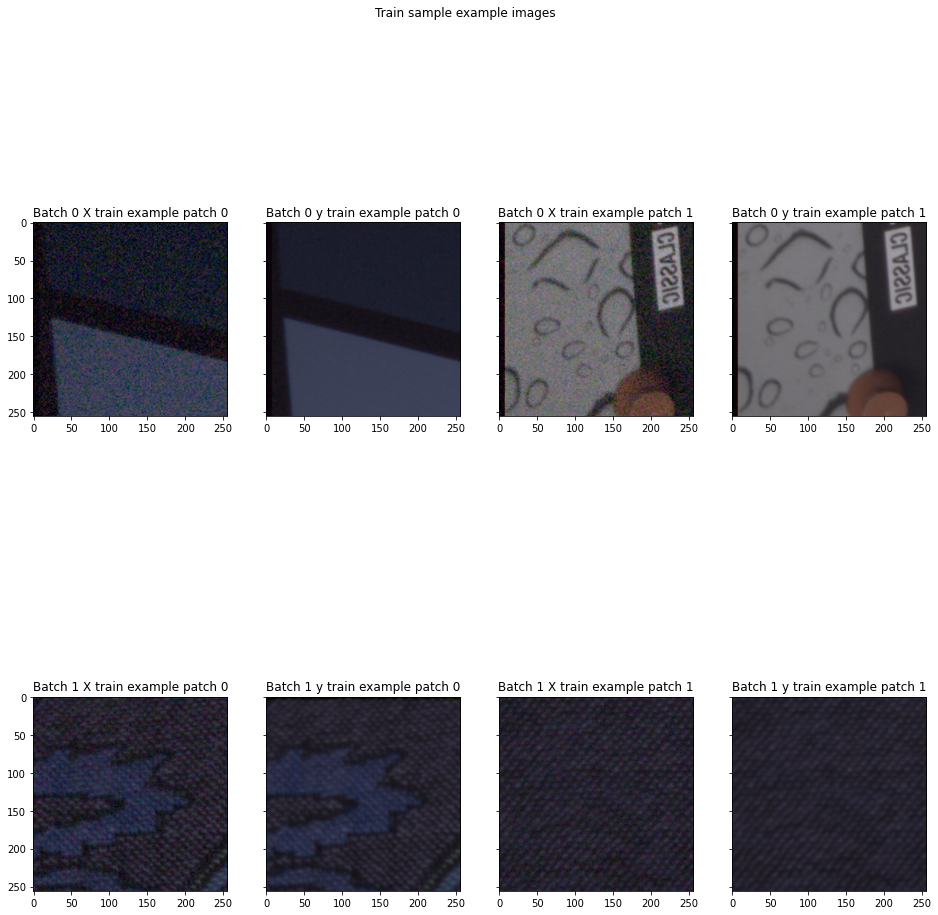

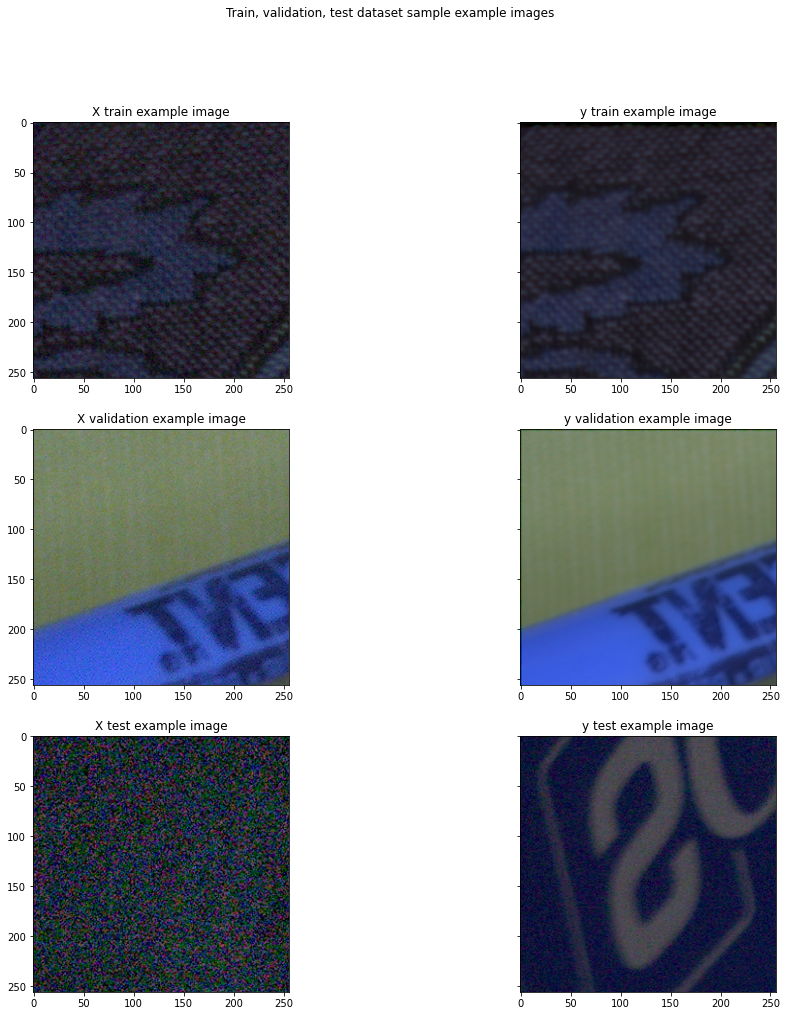

In [ ]:
model = model_pipeline(hyperparameters)

##Save model weights and bias

In [ ]:
# save model state dict
PATH = f'/content/gdrive/MyDrive/Programming/models/{project_name}.pth'

torch.save(model.state_dict(), PATH)

#INFERENCE

Run inference using already trained weights


In [ ]:
# load model weights
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
# input image
plot_dataloader = make_loader(config, test_dataset)  # take from test to plot difference

plot_features, plot_labels = next(iter(plot_dataloader))                                              


In [ ]:
outputs = model(image)
output_stage1 = outputs[0].to(device)
output_stage2 = outputs[1].to(device)

# determine losses    
loss = criterion(outputs, mini_batch_images, mini_batch_labels, data_range=1.0, reduction='mean').to(device)